### Feature Extraction

In [1]:
# wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [2]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
import os

for dir_path, dir_names, file_names in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dir_names)} directories and {len(file_names)} images in {dir_path}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

In [4]:
# prepping data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images: ", end="")
train_data = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE, class_mode="categorical")
print("Testing Images: ", end="")
test_data = test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE, class_mode="categorical")

Training Images: Found 750 images belonging to 10 classes.
Testing Images: Found 2500 images belonging to 10 classes.


In [5]:
# tensorboard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
    print(f"Saving TensorBoard log files to: ./{log_dir}")
    return tensorboard_callback

In [6]:
# creating tensorflow hub model
# https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
# https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
    """
    Takes TensorflowHub URL and creates Keras Sequential model
    """
    # downloading pretrained model
    features_extractor_layer = hub.KerasLayer(model_url,
                                              trainable=False, # freeze already trained patterns
                                              name="feature_extraction_layer",
                                              input_shape=IMAGE_SHAPE+(3,)) 
    # creating model
    model = tf.keras.Sequential([
        features_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

Resnet Model

In [9]:
# creating resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [10]:
# compliling model
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [11]:
resnet_history = resnet_model.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
                 validation_data=test_data, validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", experiment_name="resnet_v2_50")])

Saving TensorBoard log files to: ./tensorflow_hub/resnet_v2_50/20230505-205857
Epoch 1/5


2023-05-05 20:58:57.569983: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 15s 586ms/step - loss: 1.9133 - accuracy: 0.3560 - val_loss: 1.1887 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 13s 540ms/step - loss: 0.9045 - accuracy: 0.7280 - val_loss: 0.8355 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 13s 537ms/step - loss: 0.6159 - accuracy: 0.8213 - val_loss: 0.7371 - val_accuracy: 0.7592
Epoch 4/5
24/24 [==============================] - 13s 549ms/step - loss: 0.4749 - accuracy: 0.8733 - val_loss: 0.7146 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 13s 536ms/step - loss: 0.3858 - accuracy: 0.8960 - val_loss: 0.6655 - val_accuracy: 0.7828


In [12]:
# loss curves plotting
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(20, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss curves")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy curves")
  plt.xlabel("epochs")
  plt.legend()

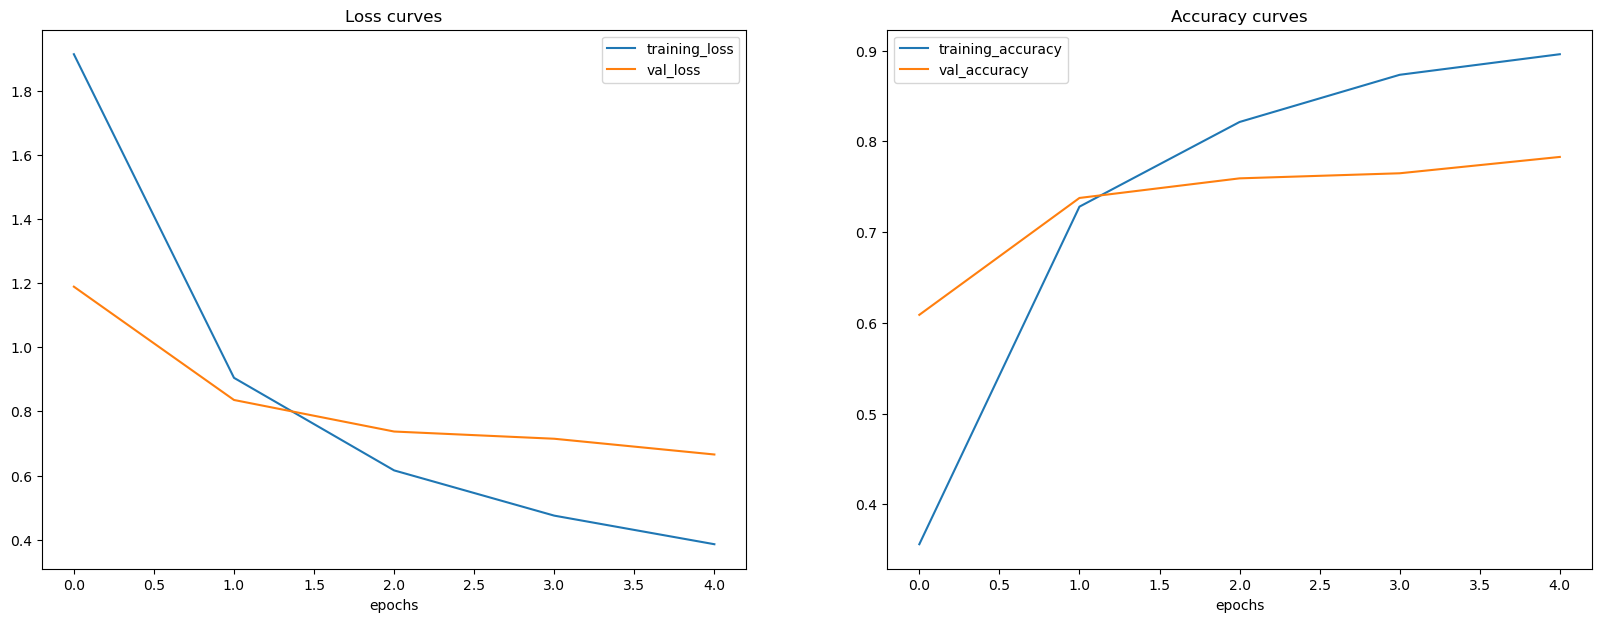

In [13]:
plot_loss_curves(resnet_history)

Efficientnet Model

In [14]:
efficientnet_model = create_model(efficientnet_url, train_data.num_classes)

In [15]:
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [16]:
efficientnet_history = efficientnet_model.fit(train_data, epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback("tensorflow_hub", 
                                                                                     experiment_name="efficientnet_b0")])

Saving TensorBoard log files to: ./tensorflow_hub/efficientnet_b0/20230505-210007
Epoch 1/5
24/24 [==============================] - 15s 463ms/step - loss: 1.8506 - accuracy: 0.4280 - val_loss: 1.2931 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 9s 385ms/step - loss: 1.0572 - accuracy: 0.7680 - val_loss: 0.8598 - val_accuracy: 0.8236
Epoch 3/5
24/24 [==============================] - 9s 384ms/step - loss: 0.7501 - accuracy: 0.8373 - val_loss: 0.6931 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 9s 384ms/step - loss: 0.6022 - accuracy: 0.8720 - val_loss: 0.6024 - val_accuracy: 0.8612
Epoch 5/5
24/24 [==============================] - 9s 386ms/step - loss: 0.5108 - accuracy: 0.8960 - val_loss: 0.5499 - val_accuracy: 0.8684


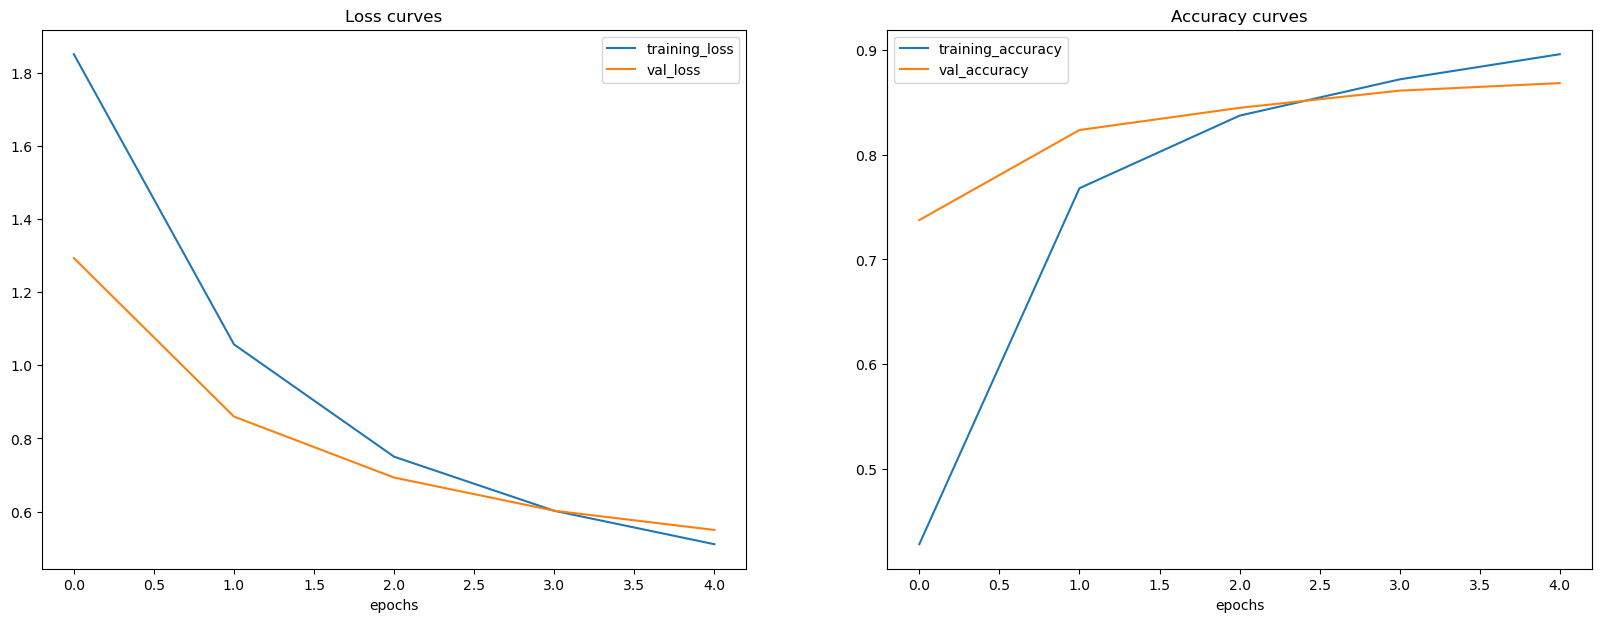

In [17]:
plot_loss_curves(efficientnet_history)

In [20]:
!tensorboard dev upload --logdir ./tensorflow_hub/ --name="EfficientNetB0 vs. ResNet50V2" --description="Comparing two different TF Hub feature extraction model architectures using 10% of training data" --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/jheGyTNbTGa75WUaO9YhBw/

[2023-05-05T21:15:14] Started scanning logdir.
[2023-05-05T21:16:45] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2023-05-05T21:16:45] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/jheGyTNbTGa75WUaO9YhBw/


In [21]:
!tensorboard dev list

https://tensorboard.dev/experiment/jheGyTNbTGa75WUaO9YhBw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of training data
	Id                   jheGyTNbTGa75WUaO9YhBw
	Created              2023-05-05 21:15:12 (1 minute ago)
	Updated              2023-05-05 21:16:45 (11 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5803326
https://tensorboard.dev/experiment/eOzHJ9RCROSnQvJG9mjCew/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of training data
	Id                   eOzHJ9RCROSnQvJG9mjCew
	Created              2023-05-05 21:09:16 (7 minutes ago)
	Updated              2023-05-05 21:10:23 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes     